In [1]:
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_dir = os.path.join("/kaggle/working/", "train")
test_dir = os.path.join("/kaggle/working/", "test")
origin_dir = os.path.join("/kaggle", "input", "garbage-classification",  "garbage_classification")
categories = os.listdir(origin_dir)

for category in categories:
    category_src_path = os.path.join(origin_dir, category)
    category_dst_path_train = os.path.join(train_dir, category)
    category_dst_path_test = os.path.join(test_dir, category)
    os.makedirs(category_dst_path_train, exist_ok = True)
    os.makedirs(category_dst_path_test, exist_ok = True)
    
    file_names = os.listdir(category_src_path)
    random.shuffle(file_names)
    length = len(file_names)
    train_file_names = file_names[:int(length*0.8)]
    test_file_names = file_names[int(length*0.8):]
    
    for name in train_file_names:
        src_path = os.path.join(category_src_path, name)
        dst_path = os.path.join(category_dst_path_train, name)
        shutil.copyfile(src = src_path,
                        dst = dst_path)
        
    for name in test_file_names:
        src_path = os.path.join(category_src_path, name)
        dst_path = os.path.join(category_dst_path_test, name)
        shutil.copyfile(src = src_path,
                        dst = dst_path)


In [3]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                             validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory("/kaggle/working/train",
                                            subset = "training", seed = 42, target_size = (299, 299))
val_data = train_gen.flow_from_directory("/kaggle/working/train",
                                            subset = "validation", seed = 42, target_size = (299, 299))
test_data = test_gen.flow_from_directory("/kaggle/working/test", seed = 42, target_size = (299, 299))

Found 9930 images belonging to 12 classes.
Found 2479 images belonging to 12 classes.
Found 3106 images belonging to 12 classes.


In [4]:
class_counts = {}

train_path = os.path.join("/kaggle/working/train")
for cls in os.listdir(train_path):
    class_path = os.path.join(train_path, cls)
    class_counts[cls] = len(os.listdir(class_path))
    
class_counts = dict(sorted(class_counts.items(), key=lambda x:x[1], reverse = True))
class_counts

{'clothes': 4260,
 'shoes': 1581,
 'paper': 840,
 'biological': 788,
 'battery': 756,
 'cardboard': 712,
 'plastic': 692,
 'white-glass': 620,
 'metal': 615,
 'trash': 557,
 'green-glass': 503,
 'brown-glass': 485}

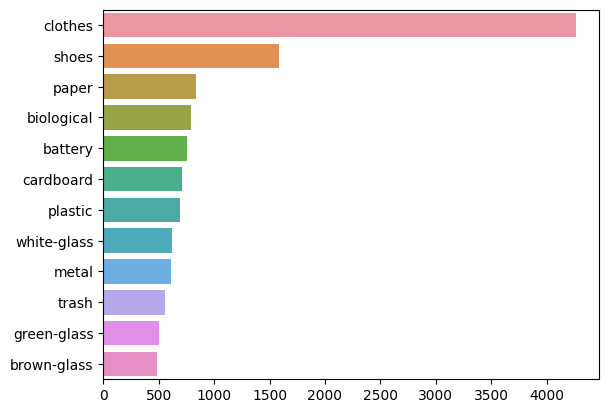

In [5]:
g = sns.barplot(x = list(class_counts.values()), y = list(class_counts.keys()))

In [6]:
class_names = list(train_data.class_indices.keys())
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

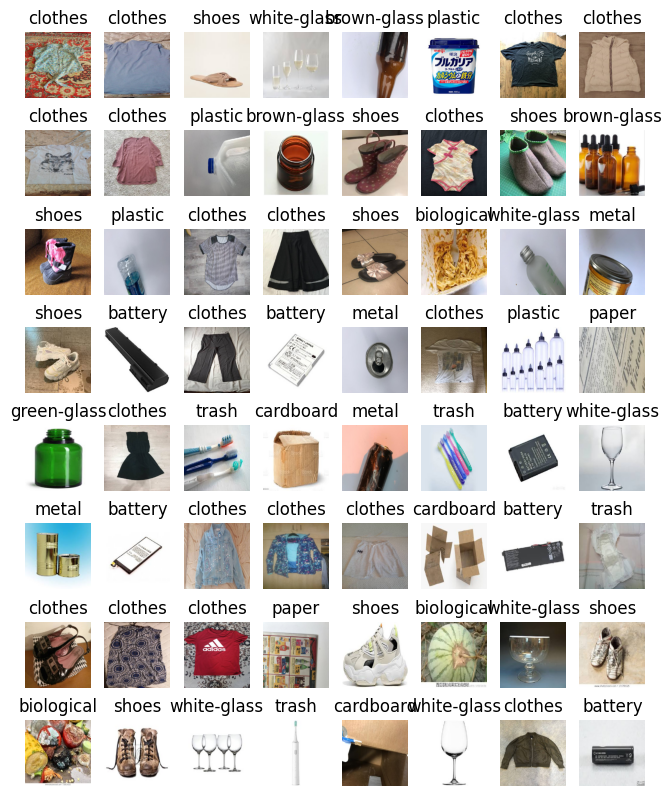

In [7]:
fig, ax = plt.subplots(8, 8, figsize = (8, 10))
for i in range(8*8):
    img = train_data[i][0][0]
    current_axis = ax[i // 8][i % 8]
    class_idx = np.argmax(train_data[i][1][0])
    current_axis.set_title(class_names[class_idx])
    current_axis.imshow(img)
    current_axis.axis("off")

In [8]:
base_model = tf.keras.applications.xception.Xception(include_top = False,
                                                 weights = "imagenet",
                                                 input_shape = (299, 299, 3))
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)
x = data_augmentation(base_model.output)
avg = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(12, activation = "softmax")(avg)
model = keras.Model(inputs = base_model.input, outputs = output)

83683744/83683744 [==============================] - 0s 0us/step


In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="top_aug_no_sh.h5",
    save_best_only=True,
    monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(patience = 10,
                                  restore_best_weights = True)
]

In [11]:
optimizer = keras.optimizers.SGD(lr = 0.2, momentum = 0.9)
model.compile(loss = "categorical_crossentropy", optimizer = optimizer,
              metrics = "accuracy")
history = model.fit(train_data,
                    epochs = 100,
                    validation_data = val_data,
                    callbacks = callbacks
                   )

Epoch 1/100
311/311 [==============================] - 98s 290ms/step - loss: 0.5600 - accuracy: 0.8620 - val_loss: 0.3641 - val_accuracy: 0.8879
Epoch 2/100
311/311 [==============================] - 97s 311ms/step - loss: 0.2584 - accuracy: 0.9355 - val_loss: 0.2920 - val_accuracy: 0.9133
Epoch 3/100
311/311 [==============================] - 97s 312ms/step - loss: 0.2119 - accuracy: 0.9496 - val_loss: 0.2765 - val_accuracy: 0.9113
Epoch 4/100
311/311 [==============================] - 97s 312ms/step - loss: 0.1790 - accuracy: 0.9555 - val_loss: 0.2535 - val_accuracy: 0.9189
Epoch 5/100
311/311 [==============================] - 97s 310ms/step - loss: 0.1612 - accuracy: 0.9587 - val_loss: 0.2556 - val_accuracy: 0.9133
Epoch 6/100
311/311 [==============================] - 97s 311ms/step - loss: 0.1482 - accuracy: 0.9631 - val_loss: 0.2377 - val_accuracy: 0.9213
Epoch 7/100
311/311 [==============================] - 97s 312ms/step - loss: 0.1386 - accuracy: 0.9663 - val_loss: 0.2314 -

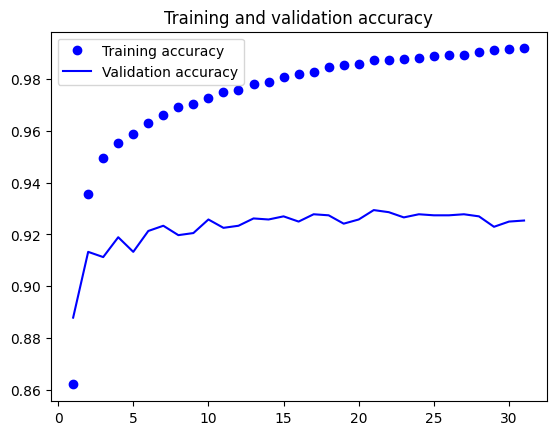

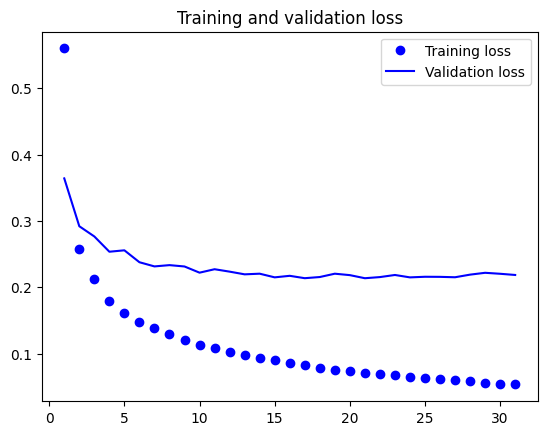

In [12]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [13]:
for layer in base_model.layers:
    layer.trainable = True

    
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="model_aug_no_sh.h5",
    save_best_only=True,
    monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(patience = 10,
                                  restore_best_weights = True)
]

In [14]:
optimizer = keras.optimizers.SGD(lr = 0.01, momentum = 0.9)
model.compile(loss = "categorical_crossentropy", optimizer = optimizer,
              metrics = "accuracy")
history = model.fit(train_data,
                    epochs = 100,
                    validation_data = val_data,
                    callbacks = callbacks
                   )

Epoch 1/100
311/311 [==============================] - 327s 988ms/step - loss: 0.1306 - accuracy: 0.9606 - val_loss: 0.2015 - val_accuracy: 0.9379
Epoch 2/100
311/311 [==============================] - 303s 975ms/step - loss: 0.0275 - accuracy: 0.9932 - val_loss: 0.1521 - val_accuracy: 0.9568
Epoch 3/100
311/311 [==============================] - 303s 975ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.1471 - val_accuracy: 0.9589
Epoch 4/100
311/311 [==============================] - 303s 974ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.1428 - val_accuracy: 0.9621
Epoch 5/100
311/311 [==============================] - 304s 976ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.1417 - val_accuracy: 0.9629
Epoch 6/100
311/311 [==============================] - 303s 973ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.1366 - val_accuracy: 0.9645
Epoch 7/100
311/311 [==============================] - 302s 972ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0

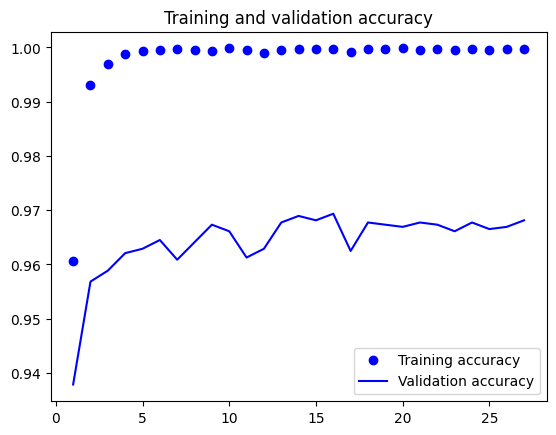

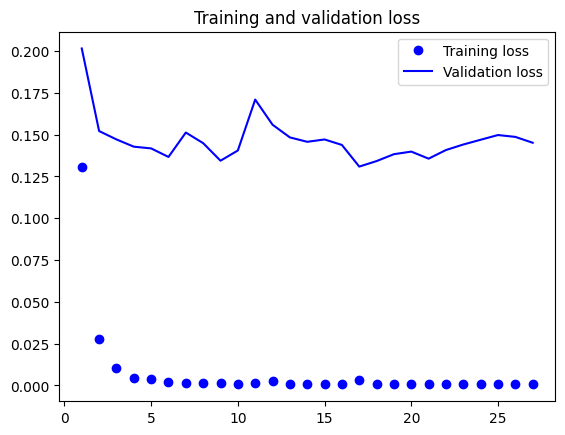

In [15]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [16]:
def get_prediction(img_path):

    class_names = list(train_data.class_indices.keys())
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis("off")
    img = tf.image.resize(img, (299, 299))
    img *= 1./255
    img = np.expand_dims(img, axis = 0)
    predictions = model.predict(img)
    plt.title(class_names[np.argmax(predictions)])